In [6]:
import os
import torch
from torch.utils.data import DataLoader
from loguru import logger
import matplotlib.pyplot as plt
from dataset_processor.dataset_loader import VideoTensorDataset
from hyvideo.vae.autoencoder_kl_causal_3d import AutoencoderKLCausal3D
from hyvideo.vae import load_vae
from hyvideo.utils.file_utils import save_videos_grid
import datetime

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

logger.info("Loading VAE...")
vae, _, s_ratio, t_ratio = load_vae(
    vae_type="884-16c-hy",           # 这里和你们项目里保持一致
    vae_precision="fp16",
    logger=logger,
    vae_path="ckpts/hunyuan-video-t2v-720p/vae",
    device=device,
)
logger.info("VAE loaded.")

# vae.enable_tiling()

# 加载数据集
dataset = VideoTensorDataset("/home/siyuan/HunyuanVideo_efficiency/results/idea_0/vae/data/tensor")
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)


2025-03-23 19:51:34.824 | INFO     | __main__:<module>:3 - Loading VAE...
2025-03-23 19:51:34.825 | INFO     | hyvideo.vae:load_vae:29 - Loading 3D VAE model (884-16c-hy) from: ckpts/hunyuan-video-t2v-720p/vae
2025-03-23 19:51:37.106 | INFO     | hyvideo.vae:load_vae:55 - VAE to dtype: torch.float16
2025-03-23 19:51:37.196 | INFO     | __main__:<module>:11 - VAE loaded.


In [ ]:
import torch
import matplotlib.pyplot as plt

def fft_latents(latent, t_group_size=11, low_freq_factor=1.0, high_freq_factor=1.0):
    """
    对给定的潜在张量 `latent` (即 z) 按组（t_group_size）进行高低频分离，
    并通过系数调整高频和低频部分的强度。
    
    - latent: 输入的潜在张量，形状 (B, C, T, H, W)
    - t_group_size: 每组时间步数
    - low_freq_factor: 调整低频部分的系数
    - high_freq_factor: 调整高频部分的系数
    """
    print(latent.shape)
    batch_size, num_channels, num_timesteps, height, width = latent.shape
    device = latent.device  # 使用输入张量的设备
    dtype = latent.dtype    # 使用输入张量的数据类型

    # 计算 t_group 数量
    num_t_groups = (num_timesteps + t_group_size - 1) // t_group_size
    latents = torch.zeros(latent.shape, device=device, dtype=dtype)

    # 设置图形的大小和子图的布局（用于可视化 FFT 幅度）
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()

    # 按组处理（这里只显示前 11 个组的可视化）
    for t_group in range(min(num_t_groups, 11)):
        t_start = t_group * t_group_size
        t_end = min((t_group + 1) * t_group_size, num_timesteps)
        
        # 取当前组的 latent
        group_latent = latent[:, :, t_start:t_end, :, :]
        
        # 1. 对当前组进行 3D FFT（在 T, H, W 维度上）
        group_fft = torch.fft.fftn(group_latent, dim=(-3, -2, -1))
        magnitude = torch.abs(group_fft)
        
        # 可视化当前组的频域幅度（取第一个 batch、通道、时间步的幅度图）
        magnitude_sample = magnitude[0, 0, 0].cpu().numpy()
        axes[t_group].imshow(magnitude_sample, interpolation='none', cmap='viridis')
        axes[t_group].set_title(f"Magnitude of FFT (Group {t_group})")
        axes[t_group].set_xlabel("Frequency (H/W)")
        axes[t_group].set_ylabel("Frequency (H/W)")
        axes[t_group].axis('on')
        
        # 2. 构造频率掩码（利用 FFT 频率坐标网格）
        # 获取当前组在 T, H, W 维度的尺寸
        T, H, W = group_latent.shape[-3:]
        # 计算各维度的频率坐标（单位采样间隔 d=1）
        t_freq = torch.fft.fftfreq(T, d=1.0).to(device)
        h_freq = torch.fft.fftfreq(H, d=1.0).to(device)
        w_freq = torch.fft.fftfreq(W, d=1.0).to(device)
        # 利用 meshgrid 构造 3D 频率坐标网格
        grid_t, grid_h, grid_w = torch.meshgrid(t_freq, h_freq, w_freq, indexing='ij')
        
        # 设定每个方向的 cutoff 参数（注意：cutoff 的单位与 t_freq, h_freq, w_freq 相同）
        # 例如：cutoff_t=0.001, cutoff_h=0.1, cutoff_w=0.1
        cutoff_t, cutoff_h, cutoff_w = 0.2, 0.5, 0.5
        # 构造椭球形低频区域，公式： (grid_t/cutoff_t)^2 + (grid_h/cutoff_h)^2 + (grid_w/cutoff_w)^2 <= 1
        radius = (grid_t / cutoff_t) ** 2 + (grid_h / cutoff_h) ** 2 + (grid_w / cutoff_w) ** 2
        freq_mask = (radius <= 1).float()
        # 将掩码扩展到与 group_fft 相同的维度：[1, 1, T, H, W]，后续会自动广播到 (B, C, T, H, W)
        mask = freq_mask[None, None, :, :, :]
        
        # 3. 分离低频和高频
        low_freq = group_fft * mask
        high_freq = group_fft * (1 - mask)
        
        # 4. 应用调整系数
        low_freq = low_freq * low_freq_factor
        high_freq = high_freq * high_freq_factor
        
        # 5. 合并低频和高频
        mixed_fft = low_freq + high_freq
        
        # 6. 逆 FFT 得到时域信号
        new_group = torch.fft.ifftn(mixed_fft, dim=(-3, -2, -1)).real
        
        # 将处理后的组存回输出张量
        latents[:, :, t_start:t_end, :, :] = new_group

    plt.tight_layout()
    plt.show()

    return latents



In [27]:
# 3. 定义 infer_vae 函数

def infer_vae(model: AutoencoderKLCausal3D,
              dataloader: DataLoader,
              device: str,
              output_dir: str,
              max_files: int = None,
              mp4: bool = True):
    """
    Perform inference using the VAE model on video tensors.
    """
    model.to(device)
    model.eval()

    os.makedirs(output_dir, exist_ok=True)

    for batch_idx, (video_tensor, file_name) in enumerate(dataloader):
        if max_files is not None and batch_idx >= max_files:
            break  # Stop processing after reaching the max number of files

        # 去掉 .pt 后缀
        file_name = file_name[0].replace(".pt", "")

        # Move to device
        video_tensor = video_tensor.to(device, dtype=torch.float16)
        logger.info(f"Processing {file_name}, video shape: {video_tensor.shape}")

        with torch.no_grad():
            posterior = model.encode(video_tensor, return_dict=False)[0]
            z = posterior.mode()
            reconstructed_video = model.decode(fft_latents(z.to(dtype=torch.float32), t_group_size=3, low_freq_factor=1.0, high_freq_factor=0.0).to(dtype=torch.float16), return_dict=False)[0]
            #reconstructed_video = model.decode(z, return_dict=False)[0]
            
        reconstructed_video = reconstructed_video.cpu().float()
        output_path = os.path.join(output_dir, f"{file_name}.pt")
        torch.save(reconstructed_video, output_path)
        logger.info(f"Saved reconstructed video to {output_path}, shape: {reconstructed_video.shape}")

        # Optionally save mp4
        if mp4:
            current_time = datetime.datetime.now().strftime("%m%d_%H%M%S")
            save_path = os.path.join(output_dir, f"{file_name}_{current_time}.mp4")
            save_videos_grid(reconstructed_video, save_path, fps=15, rescale=True)
            logger.info(f'Sample saved to: {save_path}')

2025-03-23 19:55:56.925 | INFO     | __main__:infer_vae:26 - Processing video_240p, video shape: torch.Size([1, 3, 129, 160, 284])


torch.Size([1, 16, 33, 20, 36])


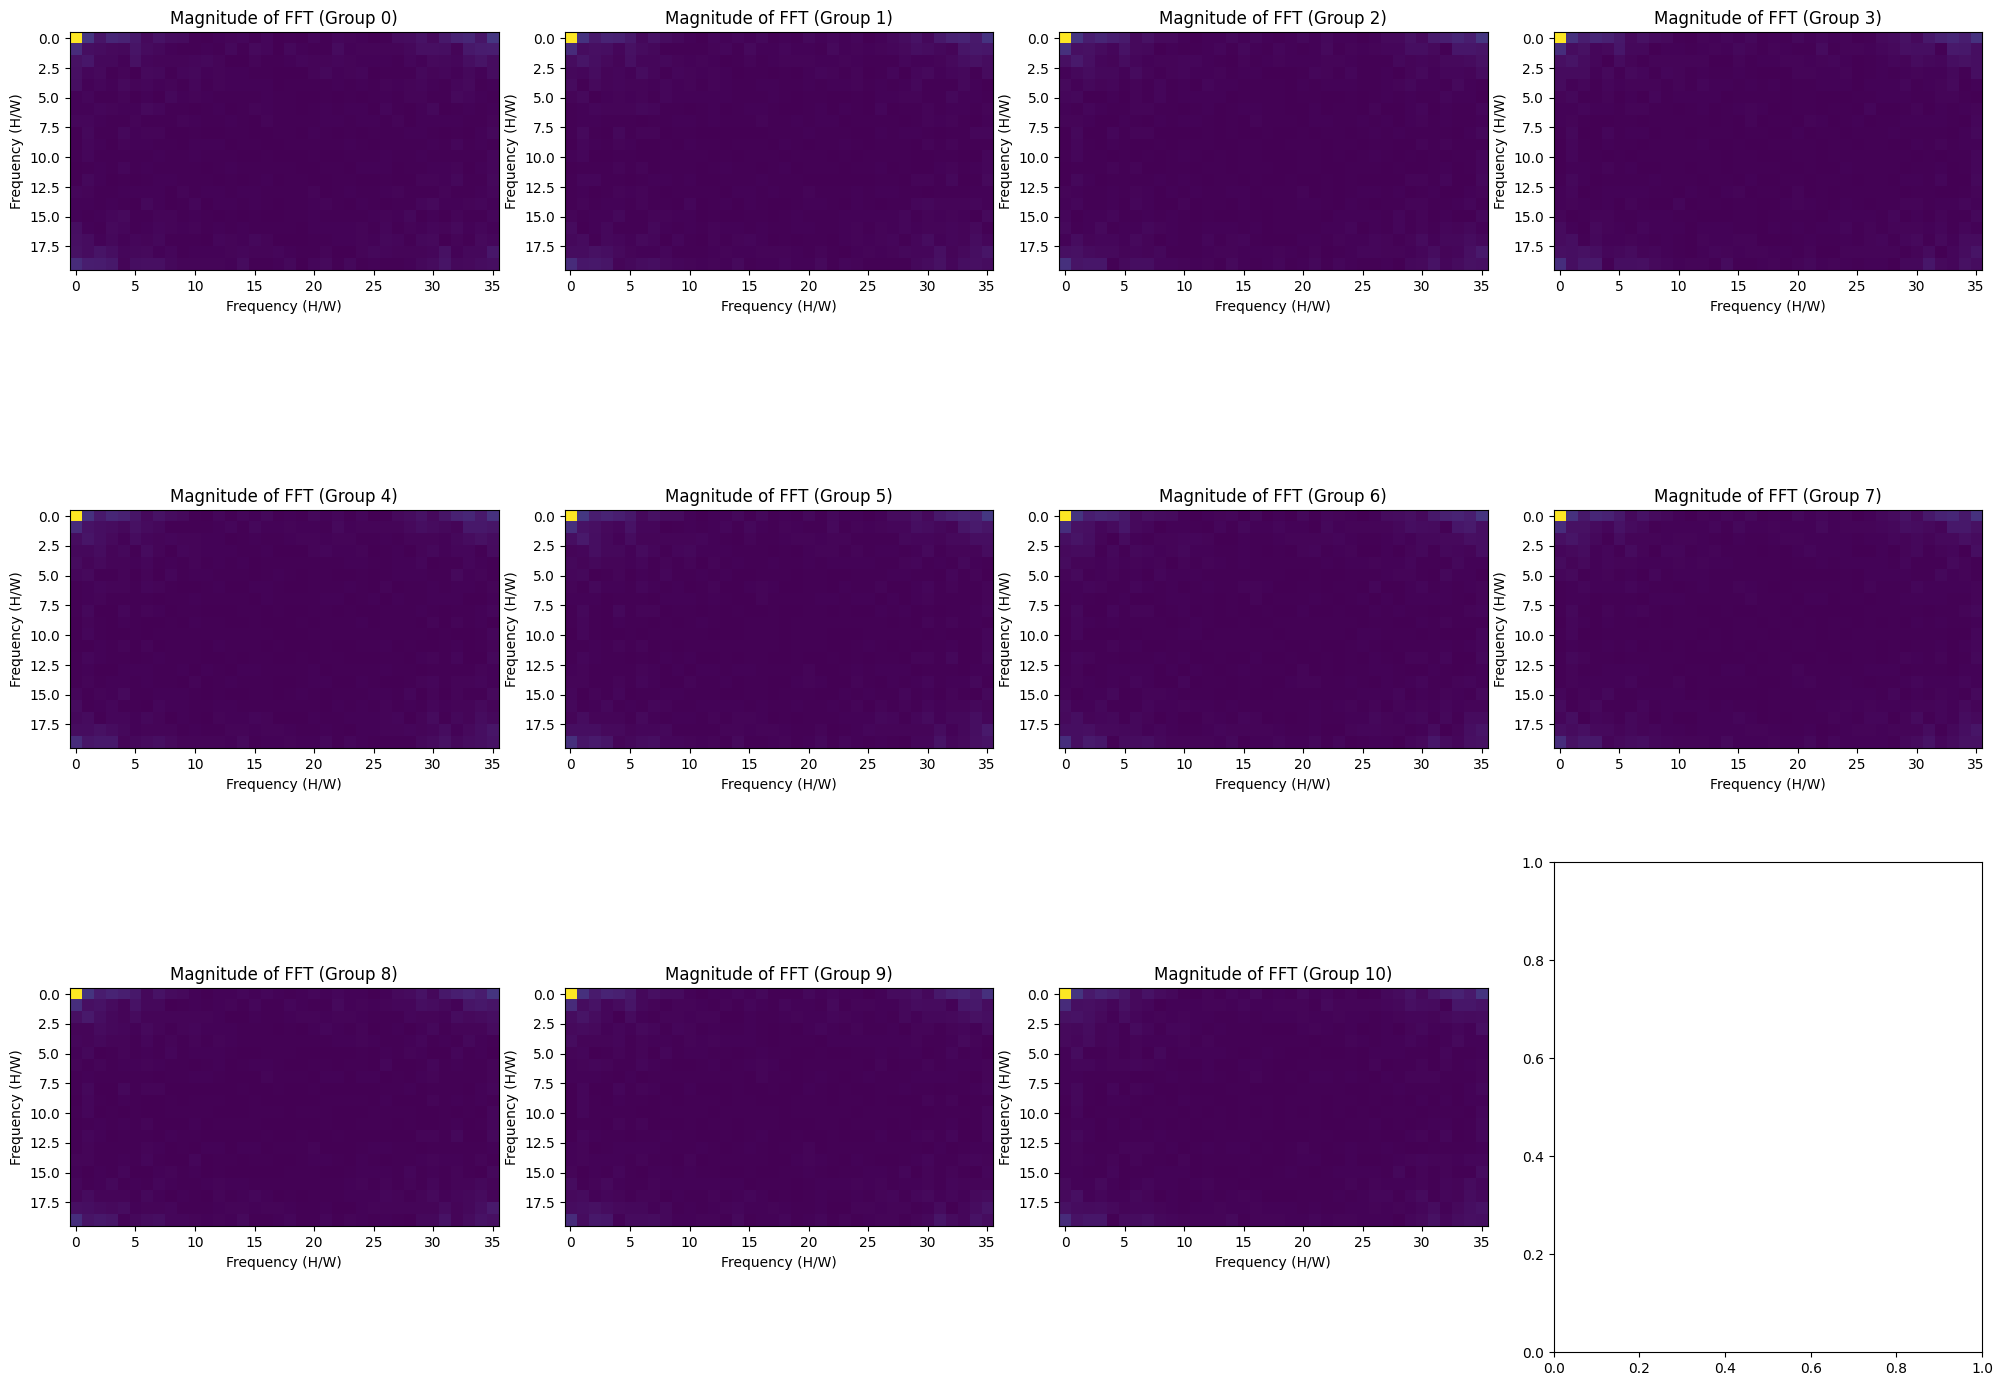

2025-03-23 19:56:00.777 | INFO     | __main__:infer_vae:37 - Saved reconstructed video to /home/siyuan/HunyuanVideo_efficiency/idea_1/video_240p.pt, shape: torch.Size([1, 3, 129, 160, 288])
2025-03-23 19:56:01.109 | INFO     | __main__:infer_vae:44 - Sample saved to: /home/siyuan/HunyuanVideo_efficiency/idea_1/video_240p_0323_195600.mp4


In [28]:
infer_vae(vae, dataloader, device, "/home/siyuan/HunyuanVideo_efficiency/idea_1/", max_files=1)